In [1]:
# -----------------------------------------------------------------------
# author: Huang Jintao
# date: 2020-5-10
#
# 该文件功能:
#   调度算法与调度效果可视化

# -----------------------------------------------------------------------


In [2]:

import pandas as pd
import numpy as np
from sortedcontainers import SortedList
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# 超参数
height, width = 32, 32  # 分成 height * width 个格子
dispatch_thresh = 200  # 某区域(abs(增减量))必须超过该调度阀值才允许调度
trans_thresh = 100  # 货车一次至少搬运100辆单车(由于成本)
max_trans = 200  # 货车一次最多搬运200辆单车
distance_thresh = 9  # 9km
delta_time = 2  # 2 * 30min = 1h

In [4]:
# 预处理
start, end = pd.read_pickle("start_out.pkl"), pd.read_pickle("end_in.pkl")
temp = start + end  #
z = np.zeros((height, width, temp.shape[-1]), dtype=temp.dtype)
for i in range(z.shape[0]):
    for j in range(z.shape[1]):
        y = slice(temp.shape[0] * i // z.shape[0], temp.shape[0] * (i + 1) // z.shape[0])
        x = slice(temp.shape[1] * j // z.shape[1], temp.shape[1] * (j + 1) // z.shape[1])
        z[i, j] = np.sum(temp[y, x], axis=(0, 1))

del temp

def distance(dy, dx):
    # return abs(dy * 0.152587890625) + abs(dx * 0.11706011227650447)  1.77
    return abs(dy * 0.152587890625 * start.shape[0] / z.shape[0]) + \
           abs(dx * 0.11706011227650447 * start.shape[1] / z.shape[1])

In [5]:
class Dispatch:

    def __init__(self, height, width,
                 dispatch_thresh,
                 trans_thresh, max_trans,
                 distance_thresh):
        """

        :param height: 区域高
        :param width: 区域宽
        :param dispatch_thresh: 调度阀值(一个区域单车abs(+-) `>= dispatch_thresh` 才会进行调度)  (保证成本)
        :param trans_thresh: 运输阀值(一辆货车最少调度多少单车 `>= trans_thresh`)  (保证成本)
        :param max_trans: 最大运输(一辆货车最大调度多少单车 `<= max_trans`)
        :param distance_thresh: 距离阀值(只调度 `<= distance_thresh` 的区域)  (保证成本)
        """
        self.height = height
        self.width = width
        self.dispatch_thresh = dispatch_thresh
        self.trans_thresh = trans_thresh
        self.max_trans = max_trans
        self.distance_thresh = distance_thresh
        # ---------------------
        self.time = None
        self.dispatch_num = 0  # 调度次数
        self.state = np.zeros((height, width), dtype=np.int16)
        self.logs = []

    def update(self, next_pred):
        """更新self.state"""
        self.state += next_pred

    def show(self, vlim=300, save_fname=None):
        z = self.state
        plt.figure(figsize=(10, 7))

        plt.xticks(np.arange(0, 33, 2), fontsize=11)
        plt.yticks(np.arange(0, 33, 2), fontsize=11)

        plt.imshow(z, origin="lower", vmin=-vlim, vmax=vlim, cmap="RdBu_r")
        plt.colorbar(shrink=0.9)
        if save_fname:
            plt.savefig(save_fname, dpi=200, bbox_inches='tight')
        plt.show()

    def dispatch(self, time=None):
        """对self.state进行调度.

        :param time: str"""
        self.time = time
        # 1. 查找出该时刻所有异常的点
        pos_arr = np.stack(np.nonzero(np.abs(self.state) >= self.dispatch_thresh), axis=-1)  # shape(NUM, 2)
        pos_arr = sorted(pos_arr, key=lambda pos: -abs(self.state[tuple(pos)]))  # -: 降序
        # 2. 调度
        for pos in pos_arr:
            pos = tuple(pos)
            if abs(self.state[pos]) < self.dispatch_thresh:  # 在其他点调度后，该点正常了
                continue
            self._dispatch_pos(pos)

    def print_logs(self, clear=False):
        for log in self.logs:
            print(log)
        if clear:
            self.clear_logs()

    def clear_logs(self):
        self.logs = []

    def _dispatch_pos(self, start_pos):  # 算法algorithm
        """调度一个点. 算法: 广搜

        :param start_pos: tuple(y, x). 需要被调度的点
        """
        # --------------------------------------------- 数据结构
        state = self.state
        pri_queue = SortedList(key=lambda item: item[0])  # 优先级队列priority queue. item: tuple(distance, pos)
        dires = [(-1, 0), (0, -1), (0, 1), (1, 0)]  # 4个方向 directions  (dy, dx)
        is_visited = np.zeros_like(state, dtype=np.bool)
        # --------------------------------------------- 算法
        # 1. 广搜/A*
        pri_queue.add([0, start_pos])  # (距起始点距离, 位置)
        while len(pri_queue) != 0:  # 队列不为空
            # ----------- 当前点的处理
            dist, curr_pos = pri_queue.pop(0)  # 当前点current, 距离最短优先
            # 非初始点, 超运输阀值, 符号相反
            if curr_pos != start_pos and abs(state[curr_pos]) >= self.trans_thresh and \
                    1 * state[start_pos] * state[curr_pos] < 0:
                # 由于会出现增现象的区域，通常会继续出现增量的情况，所以允许 超前运输
                trans_num = np.clip(state[curr_pos], -self.max_trans, self.max_trans)  # 最多运输限制
                state[curr_pos] -= trans_num
                state[start_pos] += trans_num
                self.dispatch_num += 1
                log = "id: %06d, 时间: %s, %s -> %s, 运输车辆数: %d, 距离: %.4fkm." % \
                      (self.dispatch_num, self.time, start_pos, curr_pos, int(trans_num), dist)
                self.logs.append(log)
                if 1 * state[start_pos] * (state[start_pos] - trans_num) <= 0:  # 反号了. 调度完成
                    break
            # ---------- 拓展. 遍历当前点的4个方向
            for dy, dx in dires:
                pos = curr_pos[0] + dy, curr_pos[1] + dx
                # 1. 越界
                if pos[0] < 0 or pos[1] < 0 or pos[0] >= state.shape[0] or pos[1] >= state.shape[1]:
                    continue
                # 2. 是否被访问过
                if is_visited[pos]:
                    continue
                else:
                    is_visited[pos] = True
                # 3. 对超过距离阀值的去除
                dist_start = distance(start_pos[0] - pos[0], start_pos[1] - pos[1])  # curr_pos距开始点距离
                if dist_start > self.distance_thresh:  # 不过大于最短距离值，则continue
                    continue
                # 4. 插入pri_queue
                pri_queue.add([dist_start, pos])

---------------------- 8点调度前


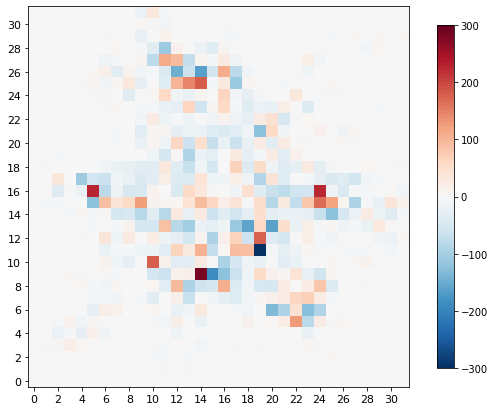

---------------------- 8点调度后


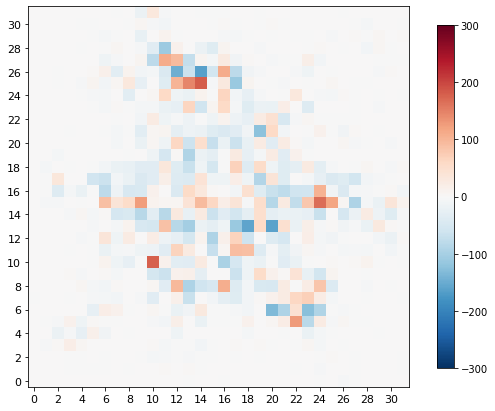

---------------------- 调度一天后
调度次数: 42
state_min: -199, state_max: 187
---------------------- 调度一天的调度信息打印
id: 000001, 时间: 07:00, (11, 16) -> (11, 15), 运输车辆数: -174, 距离: 1.7852km.
id: 000002, 时间: 07:00, (11, 16) -> (12, 15), 运输车辆数: -200, 距离: 3.5542km.
id: 000003, 时间: 07:00, (16, 5) -> (17, 5), 运输车辆数: -141, 距离: 1.7691km.
id: 000004, 时间: 08:00, (11, 19) -> (12, 19), 运输车辆数: 177, 距离: 1.7691km.
id: 000005, 时间: 08:00, (11, 19) -> (11, 14), 运输车辆数: 104, 距离: 8.9258km.
id: 000006, 时间: 08:00, (9, 14) -> (9, 15), 运输车辆数: -188, 距离: 1.7852km.
id: 000007, 时间: 08:00, (9, 14) -> (9, 16), 运输车辆数: -124, 距离: 3.5703km.
id: 000008, 时间: 08:00, (16, 5) -> (15, 5), 运输车辆数: -123, 距离: 1.7691km.
id: 000009, 时间: 08:00, (16, 5) -> (17, 4), 运输车辆数: -107, 距离: 3.5542km.
id: 000010, 时间: 08:00, (16, 24) -> (14, 25), 运输车辆数: -122, 距离: 5.3233km.
id: 000011, 时间: 09:00, (16, 21) -> (15, 21), 运输车辆数: 115, 距离: 1.7691km.
id: 000012, 时间: 09:00, (16, 21) -> (15, 23), 运输车辆数: 123, 距离: 5.3394km.
id: 000013, 时间: 09:00, (16, 21) -> (16, 18), 

In [6]:
d = Dispatch(height, width, dispatch_thresh, trans_thresh, max_trans, distance_thresh)
for i in range(z.shape[2]):
    if i == 48:
        # 一天后
        print("---------------------- 调度一天后")
        print("调度次数: %d" % d.dispatch_num)  # 调度次数: 42
        print("state_min: %d, state_max: %d" % (d.state.min(), d.state.max()))  # state_min: -199, state_max: 187
        # 打印调度信息
        print("---------------------- 调度一天的调度信息打印")
        d.print_logs(clear=True)
        print("---------------------- 打印完毕", flush=True)

    x = z[..., i]
    d.update(x)
    if i % delta_time == 0 and i != 0:
        # 绘制调度前后的区别
        if i == 16:
            print("---------------------- 8点调度前")
            d.show(vlim=300, save_fname="8点调度前.png")
            d.dispatch(time="%02d:%02d" % (i // 2, i % 2 * 30))
            print("---------------------- 8点调度后")
            d.show(vlim=300, save_fname="8点调度后.png")
        else:
            d.dispatch(time="%02d:%02d" % (i // 2, i % 2 * 30))
            

---------------------- 调度一周后
调度次数: 542
state_min: -185, state_max: 178


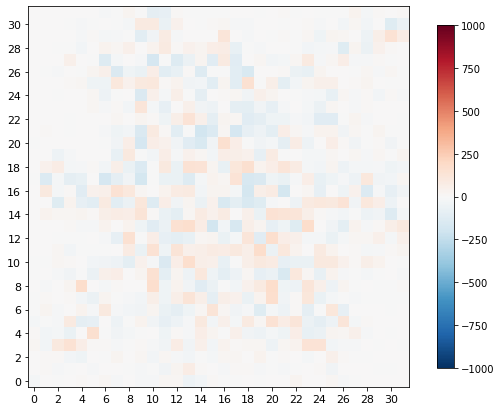

In [7]:
# 不进行调度与调度的区别
print("---------------------- 调度一周后")
print("调度次数: %d" % d.dispatch_num)  # 调度次数: 542
print("state_min: %d, state_max: %d" % (d.state.min(), d.state.max()))  # state_min: -185, state_max: 177

d.show(vlim=1000, save_fname="调度一周后.png")


---------------------- 不调度一周后
调度次数: 0
state_min: -2988, state_max: 2694


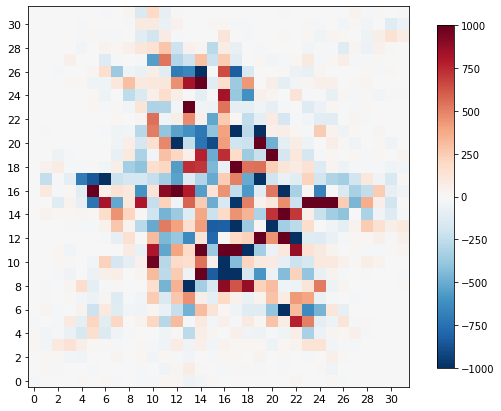

In [8]:
d = Dispatch(height, width, dispatch_thresh, trans_thresh, max_trans, distance_thresh)
for i in range(z.shape[2]):
    x = z[..., i]
    d.update(x)
print("---------------------- 不调度一周后")
print("调度次数: %d" % d.dispatch_num)  # 调度次数: 0
print("state_min: %d, state_max: %d" % (d.state.min(), d.state.max()))  # state_min: -2991, state_max: 2694
d.show(vlim=1000, save_fname="不调度一周后.png")